# RQ2: Como o sentimento afeta o engajamento dos usuários, especialmente novatos?

In [ ]:
import pandas as pd
import helper
import numpy as np


#Get post + user data
post_data = helper.load_post_data('./data/analyzed.jsonl')
user_data = helper.load_user_data('./data/dump-users.json')

## Analisando engajamento em torno do sentimento da **pergunta original**: número médio de respostas, comentários, score

In [40]:
ans = {'unanswered': [0,0,0], 'total': [0,0,0], 
       'response_times': [[], [], []], 'num_answers': [[], [], []], 'scores': [[], [], []]}

for id, post in post_data.items():
    #Check question sentiment
    q_sent = post['body_sentiment']

    ans['total'][q_sent] += 1
    ans['num_answers'][q_sent].append(len(post['answers']))
    ans['scores'][q_sent].append(post['score'])
    
    if len(post['answers']) == 0: ans['unanswered'][q_sent] += 1
    else:
        quickest = (min([a['creation_date'] for a in post['answers']]) - post['creation_date'])
        ans['response_times'][q_sent].append(quickest.seconds / 3600)

In [42]:
print('Number of question for each answer:', ans['total'])

print('Number of unanswered question per question sentiment:')

for u,t in zip(ans['unanswered'], ans['total']):
    print(u / t)

print('Metric: Amount of anwers per question sentiment')
print('Mean', [float(np.mean(a)) for a in ans['num_answers']])
print('Standard deviation:', [float(np.std(a)) for a in ans['num_answers']])

print('\nMetric: Question score per question sentiment')
print('Mean:', [float(np.mean(a)) for a in ans['scores']])
print('Standard deviation:', [float(np.std(a)) for a in ans['scores']])

print('\nMetric: Response time per question sentiment')
print('Mean:', [float(np.mean(a)) for a in ans['response_times']])
print('Standard deviation:', [float(np.std(a)) for a in ans['response_times']])

Number of question for each answer: [120803, 720892, 158305]
Number of unanswered question per question sentiment:
0.14792678989760188
0.14028176203925138
0.14839076466315024
Metric: Amount of anwers per question sentiment
Mean [1.3536998253354635, 1.339779051508409, 1.299655727867092]
Standard deviation: [1.2015125090161722, 1.1515028855277245, 1.039488274165542]

Metric: Question score per question sentiment
Mean: [1.3843613155302434, 1.4315445309422217, 0.9691481633555479]
Standard deviation: [9.173996349083579, 10.303536846208223, 4.865474532057022]

Metric: Response time per question sentiment
Mean: [3.7243113130763588, 3.9938617876231026, 4.071148335237191]
Standard deviation: [6.14632485563535, 6.278911002127294, 6.3315843155574125]


<Axes: >

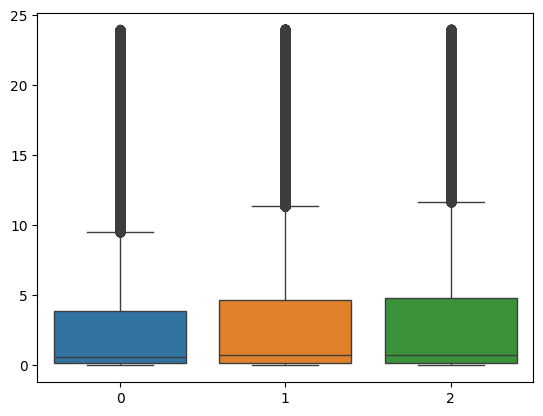

In [41]:
import seaborn as sns

sns.boxplot(ans['response_times'])